# DBSCAN and Hierarchical Clustering Analysis of Customer Shopping Trends

## 1.0 Business understanding

### 1.1 Business objective

### 1.2 Situational assessment

* Patterns and behaviors exhibited by customers are important to retailers.
* Analyzing purchasing pattern requires analysis of product categories, purchasing channels, and customer demographics.
* Analysing customer behavior requires purchase frequency, tranaction volume, and seasonality.
* Providing retail decision makers with insights from their customer data can create opportunities to respond to trends in purchasing patterns and behavior.

**Research Question #1:**
Are there distinct clusters of shopping trends?

**Hypothesis Couplet**

Null Hypothesis (H<sub>0</sub>): There are no differentiated clusters of shopping trends.


Alternate Hypothesis (H<sub>1</sub>): There are differentiated clusters of shopping trends.


## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Data mining goals

#### 2.1.2 Import libraries

In [288]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import itertools
import graphviz
import warnings

In [289]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score ,f1_score, silhouette_score
from sklearn.metrics import silhouette_score as ss
from sklearn.decomposition import PCA
from sklearn import decomposition
from IPython.display import clear_output
from mlxtend.plotting import plot_decision_regions
from google.colab import files
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, IsolationForest, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from xgboost import XGBClassifier

#### 2.1.3 Suppress warnings

In [290]:
warnings.filterwarnings('ignore')

#### 2.1.4 Data ingestion

In [291]:
# Import dataset
#create 2-dimensional dataFrames from a imported data.
#Choose the local file (baseball.csv).
#NOTE: YOU WILL NEED TO ALLOW THIRD-PARTY COOKIES FROM THIS SITE colab.research.google.com
from google.colab import files
uploaded = files.upload()

Saving shopping_trends.csv to shopping_trends (2).csv


In [292]:
file_name = "shopping_trends.csv"

In [293]:
# Load dataset
df=pd.read_csv(file_name)

In [294]:
pd.set_option('display.max_columns', None)
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


#### 2.1.5 Data description

**High Level Data Dictionary**

* Customer ID
* Age
* Gender
* Item Purchased
* Category
* Purchase Amount (USD)
* Location
* Size
* Color
* Season
* Review Rating
* Subscription Status
* Payment Method
* Shipping Type
* Discount Applied
* Promo Code Used
* Previous Purchases
* Preferred Payment Method
*Frequency of Purchases

In [295]:
df.columns

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases'],
      dtype='object')

In [296]:
df.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [297]:
df.describe(include='object')

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Credit Card,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,696,675,2223,2223,677,584


### 2.2 Data quality

#### 2.2.1 Check for missing values

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

There are no missing values.

#### 2.2.2 Check for outliers

In [299]:
feature_df = df.select_dtypes(include='number')

In [300]:
rows, cols = 2, 3
num_columns = len(feature_df.columns)
num_plots = min(rows * cols, num_columns)

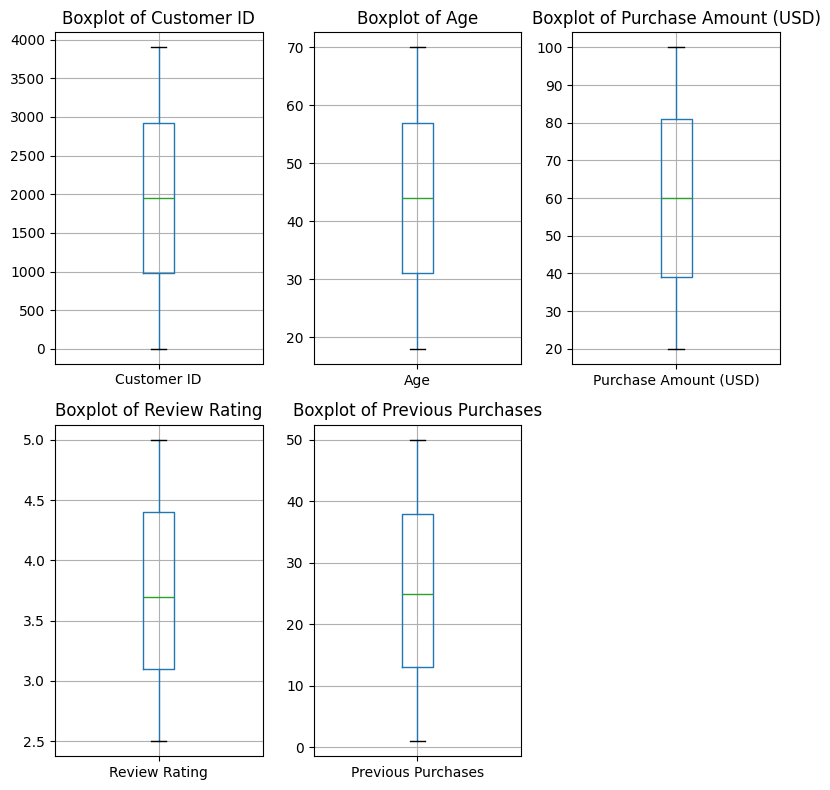

In [301]:
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    feature_df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are no outliers.

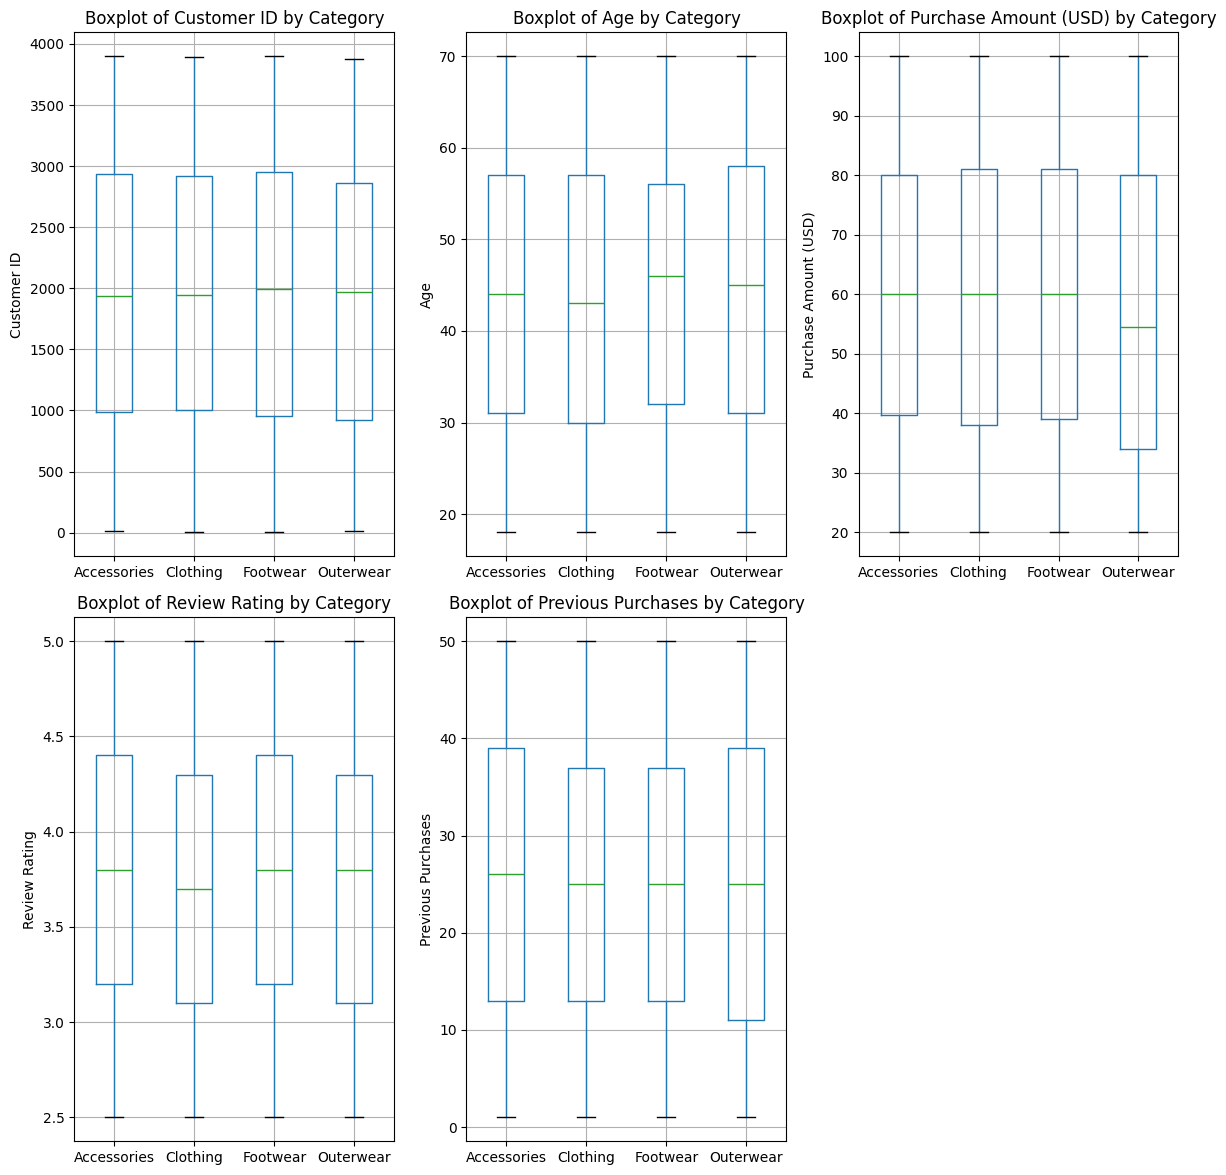

In [302]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    df.boxplot(column=column, by='Category', ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} by Category')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column)

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

fig.suptitle('')
plt.tight_layout()
plt.show()

#### 2.2.3 Check for duplicates

In [303]:
df.duplicated().sum()

np.int64(0)

There are no duplicate rows.

### 2.3 Exploratory data analysis

#### 2.3.1 Check distributions of numeric variables

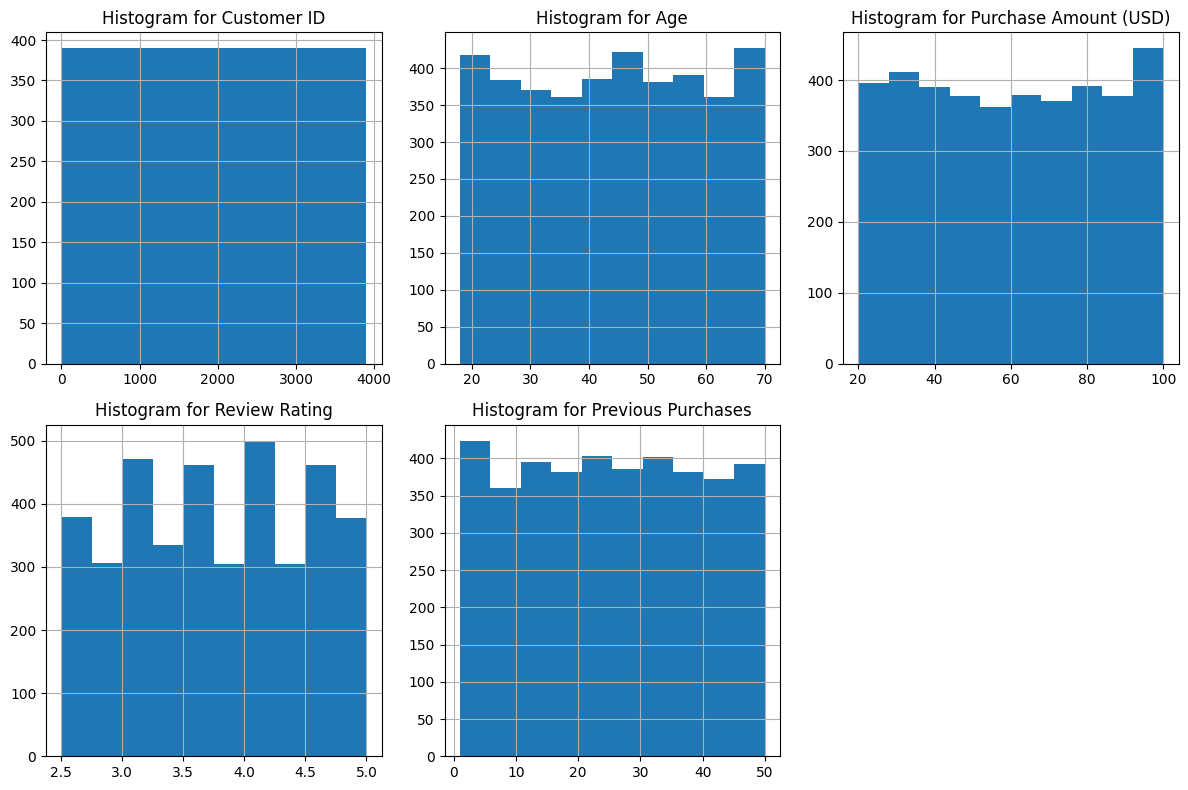

In [304]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

# Select only numeric columns for histogram plotting
numeric_feature_df = feature_df.select_dtypes(include=np.number)
num_numeric_columns = len(numeric_feature_df.columns)
num_plots = min(rows * cols, num_numeric_columns)


for i, column in enumerate(numeric_feature_df.columns[:rows * cols]):
    numeric_feature_df.hist(column=column, ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2.3.2 Check density of numeric variables

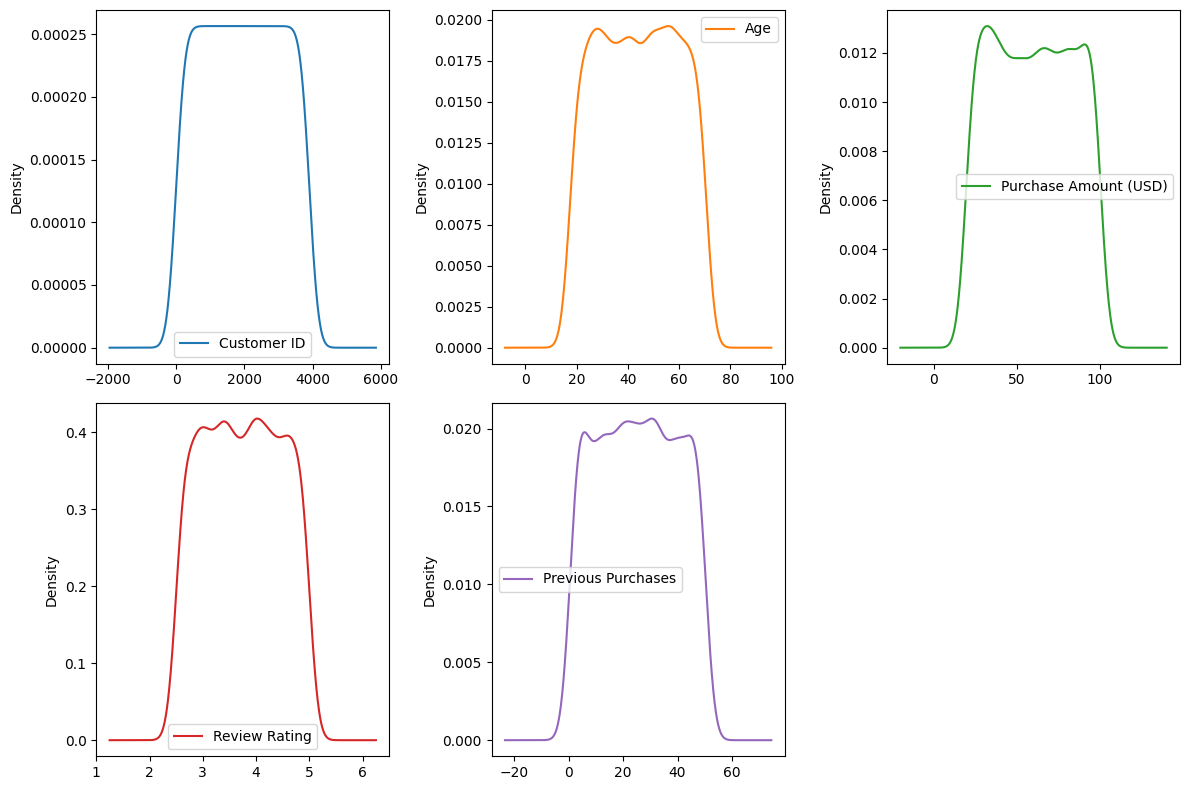

In [305]:
feature_df.plot(kind='density', subplots=True, layout=(2, 3), figsize=(12, 8), sharex=False)
plt.tight_layout()
plt.show()

#### 2.3.3 Check skewness of continuous numeric variables

In [306]:
numeric_feature_df.skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
Customer ID,0.000000
Age,-0.006380
Purchase Amount (USD),0.012702
Review Rating,0.004525
Previous Purchases,0.003121


No numeric features are skewed.

#### 2.3.3 Check corrleations of numeric variables

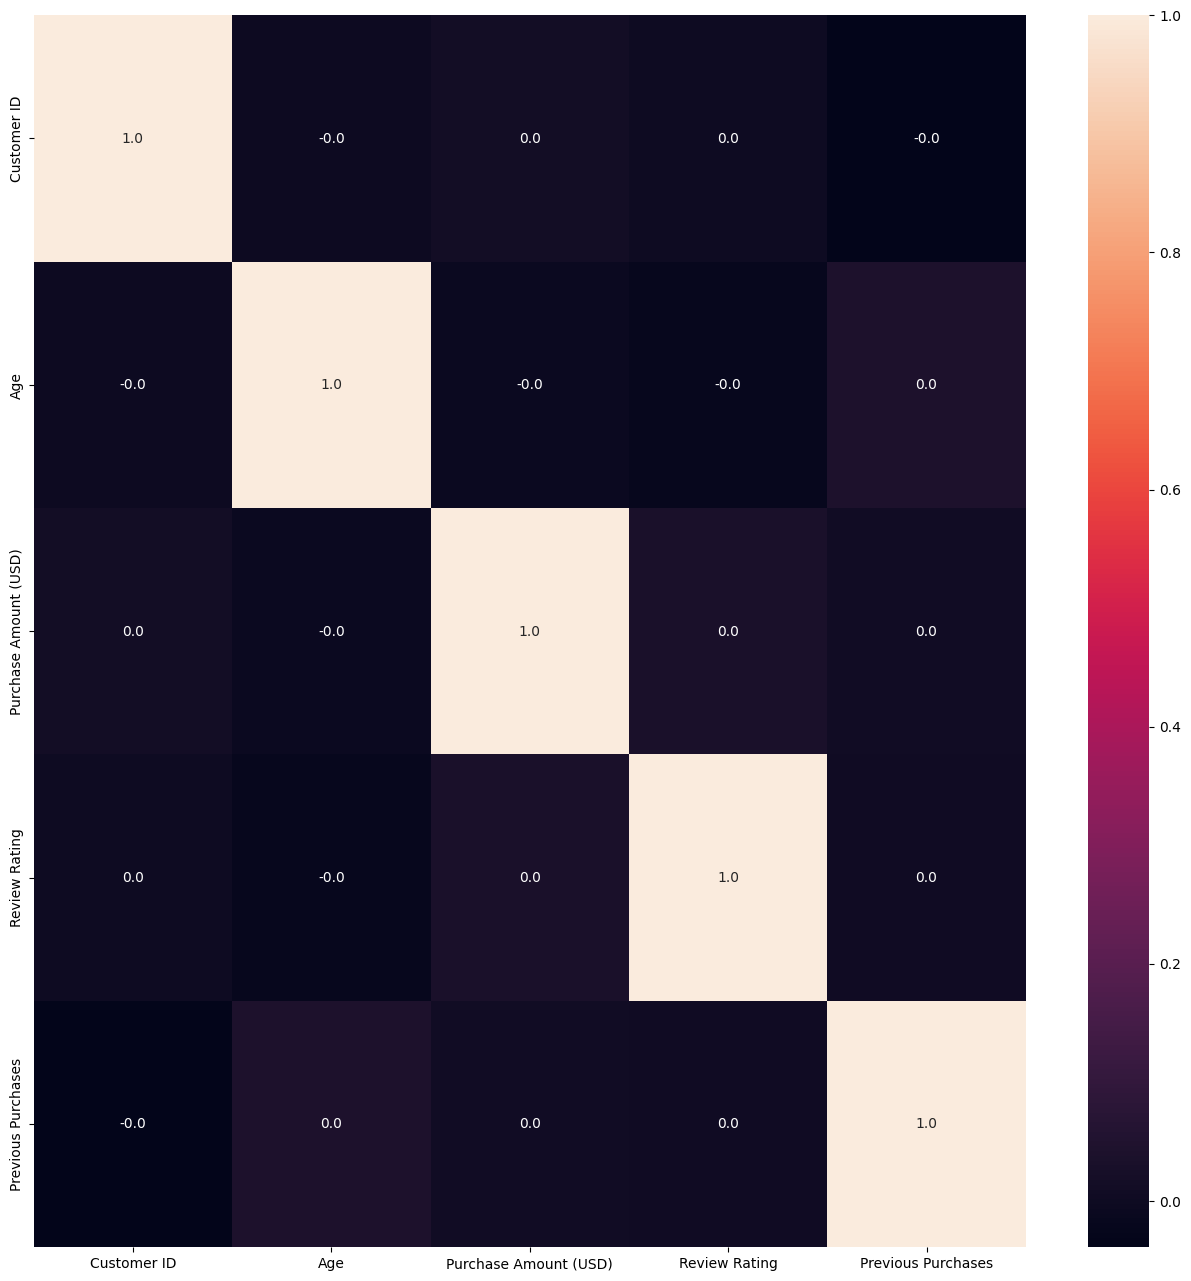

In [307]:
plt.figure(figsize=[16,16],facecolor='white')
sns.heatmap(feature_df.corr(), annot=True, fmt=".1f")
plt.show()

No numeric features are correlated.

#### 2.3.4 Number of customers by category for categorical features

In [308]:
def cust_purchase_cat(column):
  plt.figure(figsize=(12,6))
  ax = sns.countplot(x=column, hue='Category', data=df)
  for val in ax.containers:
    ax.bar_label(val)
  plt.title(f'Customers by Category for {column}')
  plt.show()

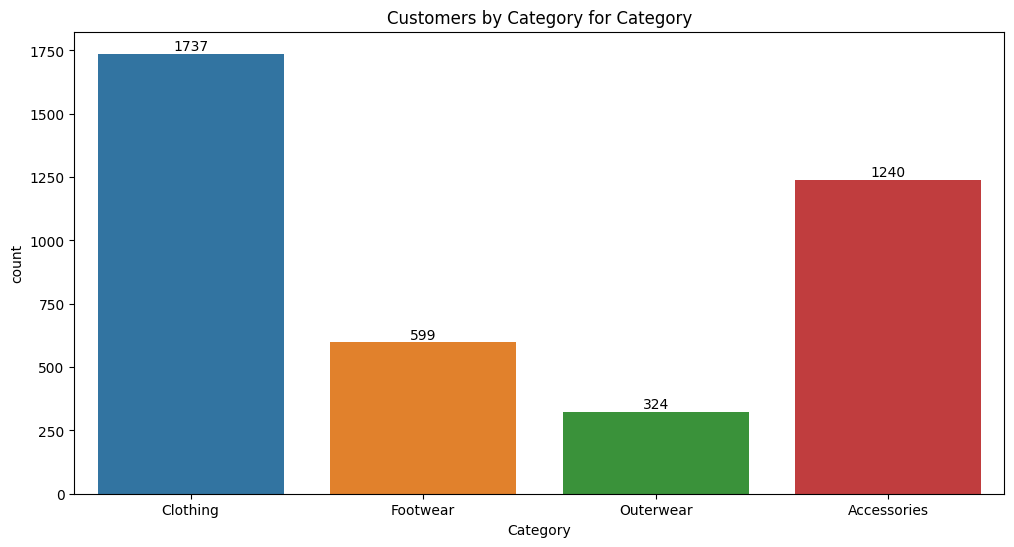

In [309]:
cust_purchase_cat('Category')

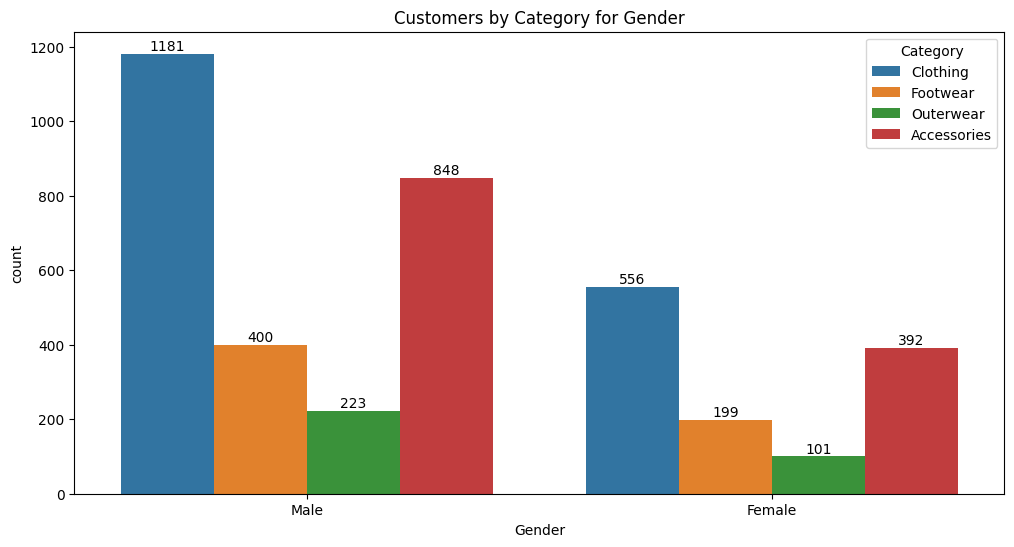

In [310]:
cust_purchase_cat('Gender')

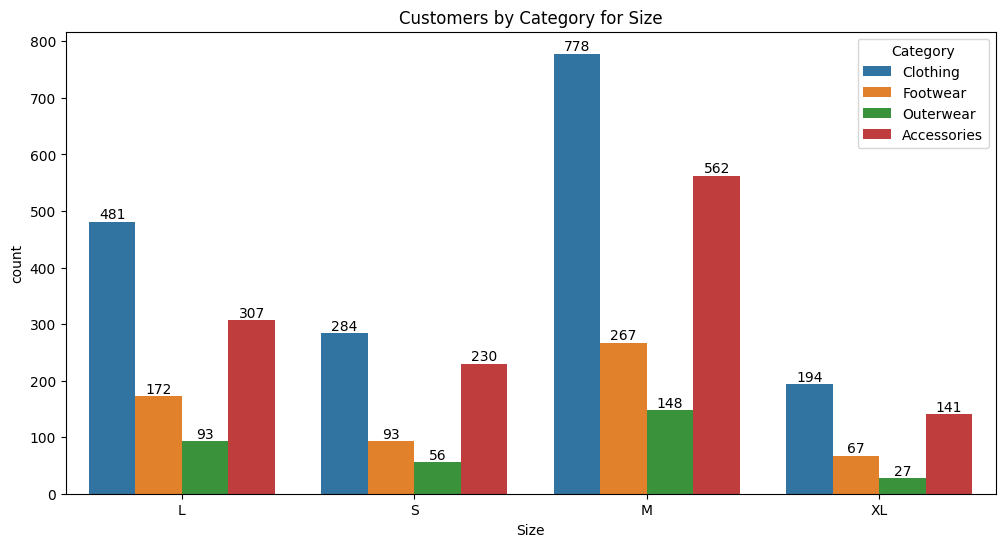

In [311]:
cust_purchase_cat('Size')

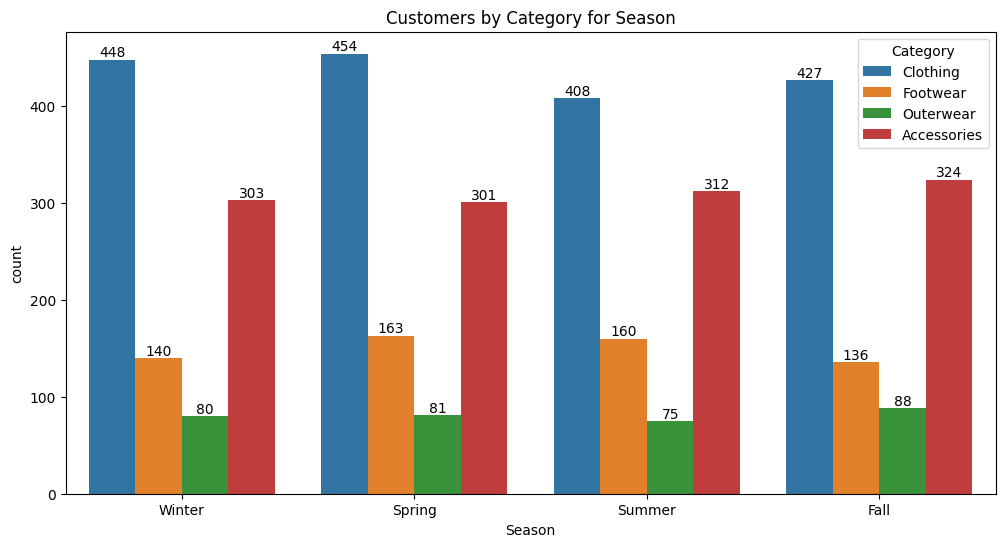

In [312]:
cust_purchase_cat('Season')

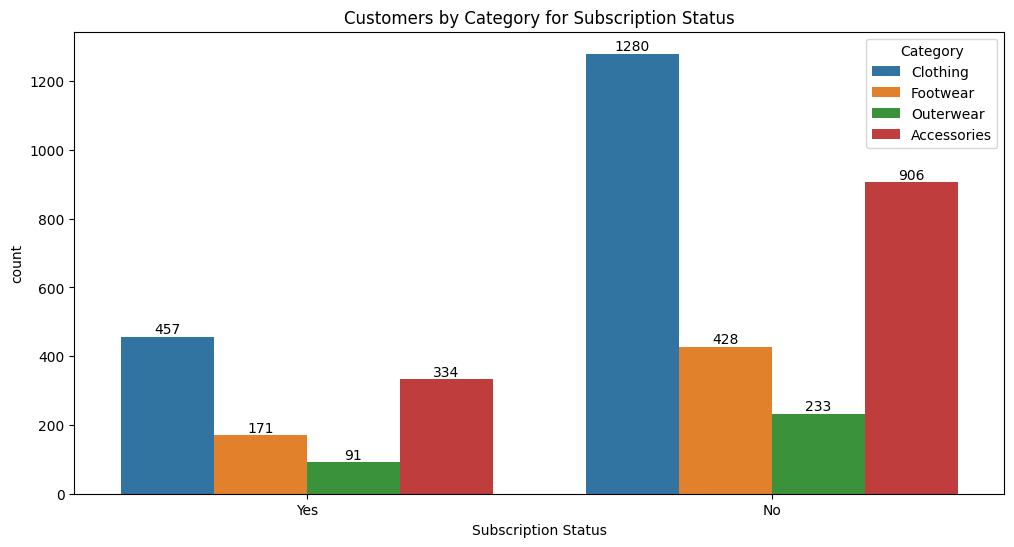

In [313]:
cust_purchase_cat('Subscription Status')

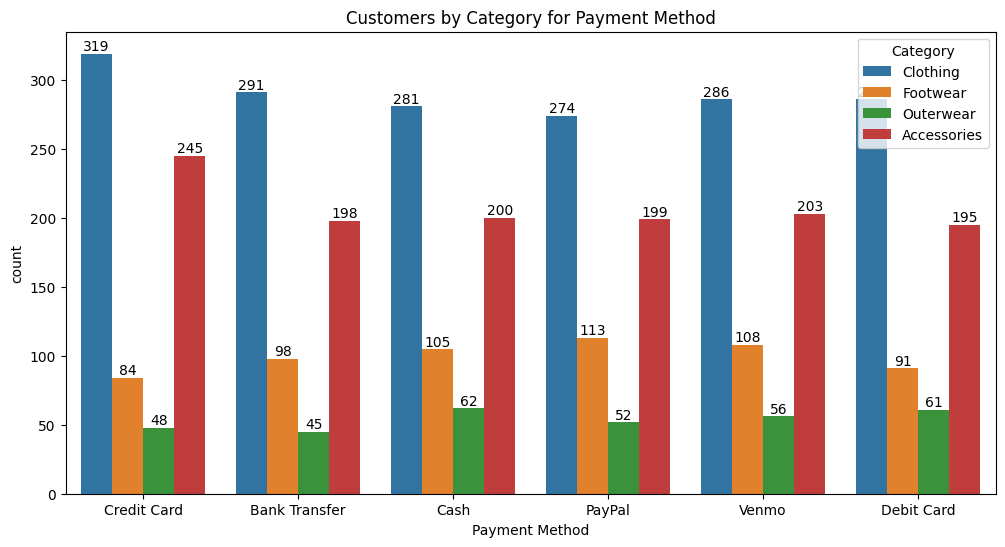

In [314]:
cust_purchase_cat('Payment Method')

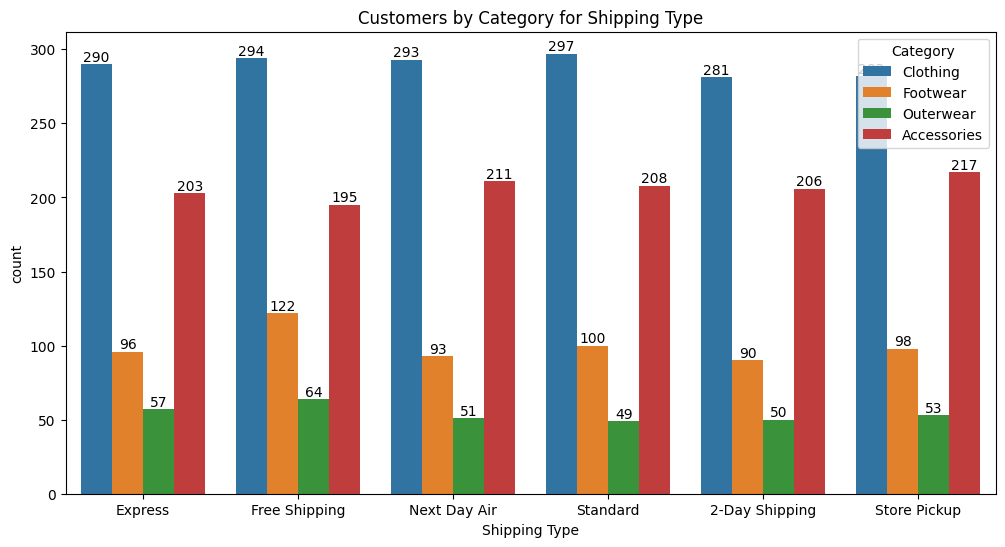

In [315]:
cust_purchase_cat('Shipping Type')

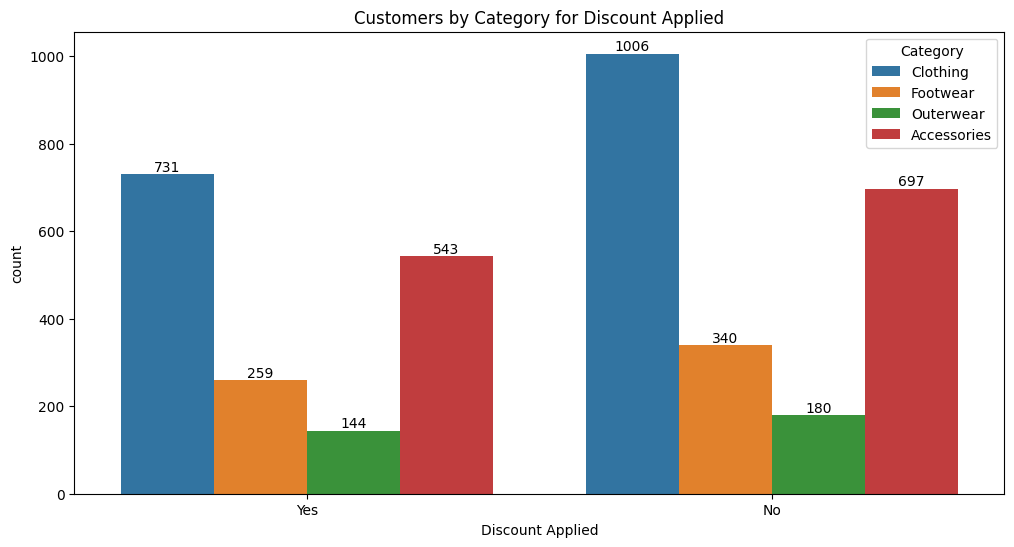

In [316]:
cust_purchase_cat('Discount Applied')

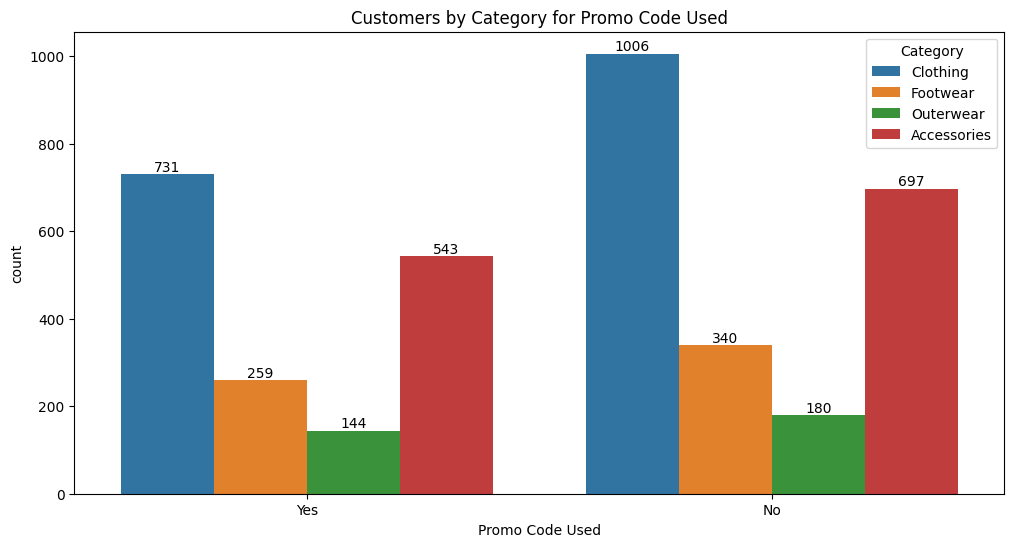

In [317]:
cust_purchase_cat('Promo Code Used')

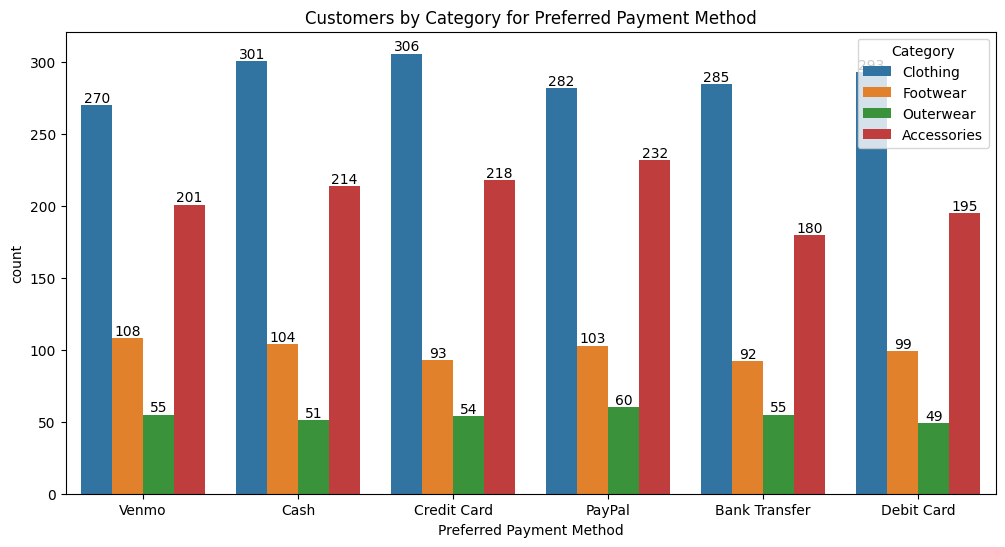

In [318]:
cust_purchase_cat('Preferred Payment Method')

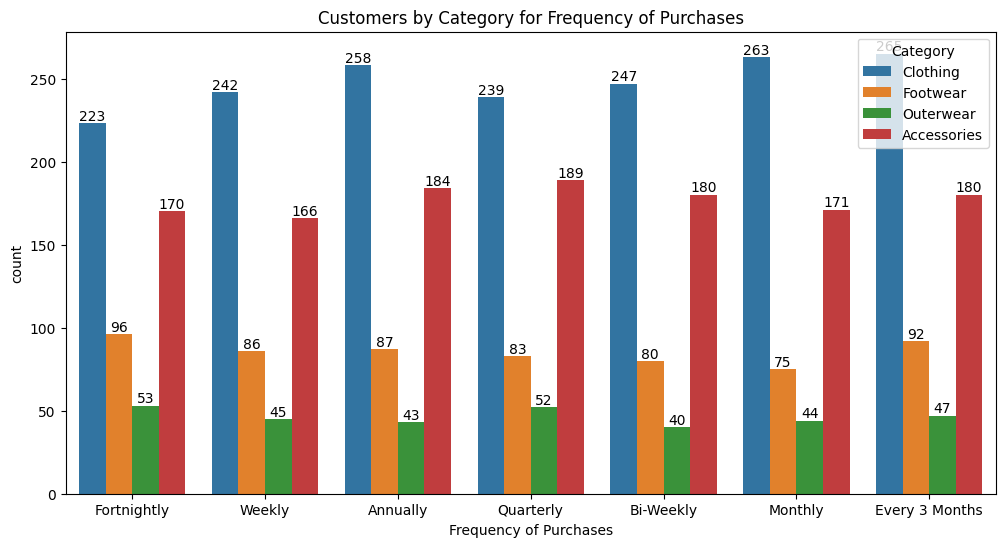

In [319]:
cust_purchase_cat('Frequency of Purchases')

#### 2.3.5 Number of customers by category for numeric features

In [320]:
def cust_purchase_num(column):
  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  sns.histplot(x=column, hue='Category', data=df)
  plt.title(f'Distribution of {column} by Category')

  plt.subplot(1,2,2)
  sns.boxplot(x='Category', y=column, data=df)
  plt.title(f'Distribution of {column} by Category')

  plt.tight_layout()
  plt.show()

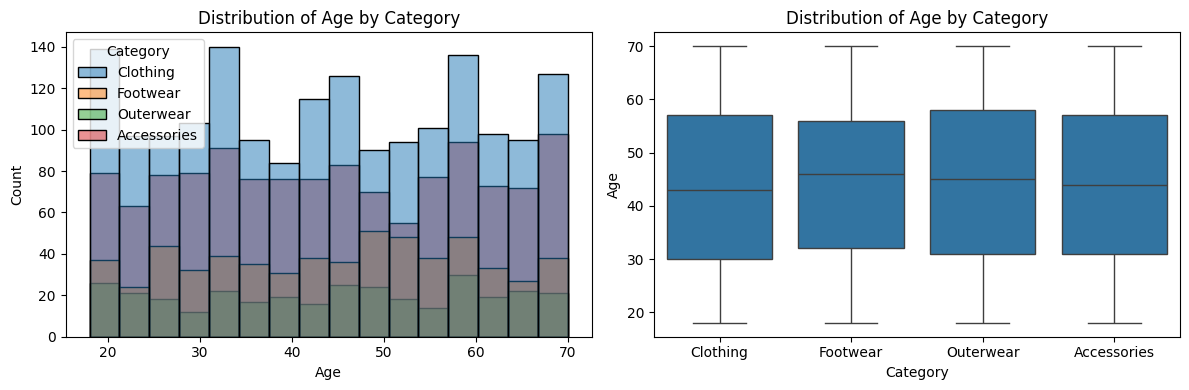

In [321]:
cust_purchase_num('Age')

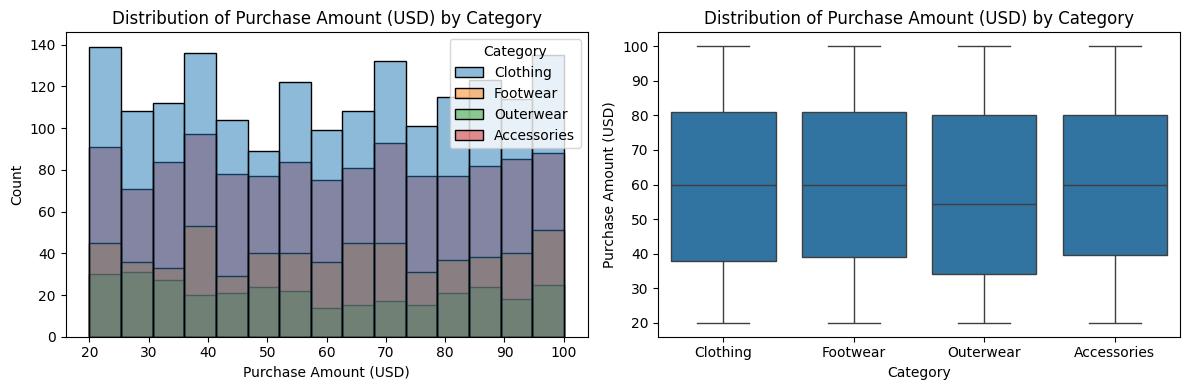

In [322]:
cust_purchase_num('Purchase Amount (USD)')

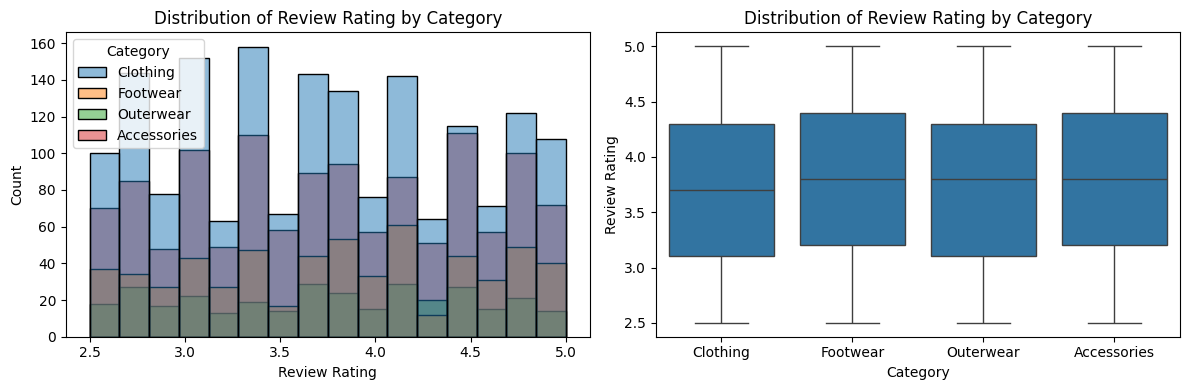

In [323]:
cust_purchase_num('Review Rating')

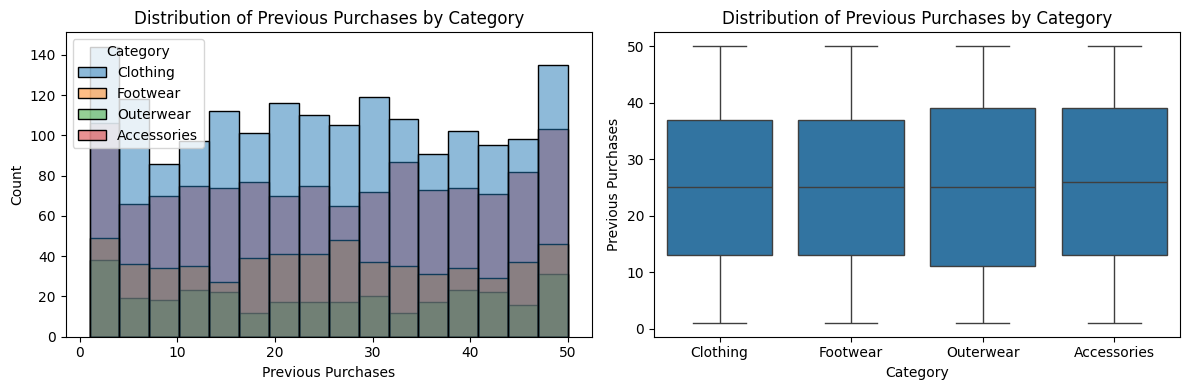

In [324]:
cust_purchase_num('Previous Purchases')

## 3.0 Data preprocessing

### 3.1 Data cleansing

#### 3.1.1 No missing values

#### 3.1.2 No duplicate rows

#### 3.1.3 No highly correlated features

#### 3.1.4 Remove unnecessary features

In [325]:
df.drop(columns=['Customer ID'],inplace=True)

### 3.2 Feature engineering

#### 3.2.1 Feature encoding

##### 3.2.1.1 One-hot encoding

In [326]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [327]:
onehot_encoding = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used', 'Category']

In [328]:
encoded_df_list = []

In [329]:
for col in onehot_encoding:
    transformed = onehot_encoder.fit_transform(df[[col]])
    feature_names = [f"{col}_{cat}" for cat in onehot_encoder.categories_[0]]
    encoded_df_list.append(pd.DataFrame(transformed, columns=feature_names, index=df.index))

In [330]:
df_encoded = pd.concat([df.drop(columns=onehot_encoding)] + encoded_df_list, axis=1)

In [331]:
df_encoded.head()

,Age,Item Purchased,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Payment Method,Shipping Type,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear
0,55,Blouse,53,Kentucky,L,Gray,Winter,3.1,Credit Card,Express,14,Venmo,Fortnightly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,19,Sweater,64,Maine,L,Maroon,Winter,3.1,Bank Transfer,Express,2,Cash,Fortnightly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,50,Jeans,73,Massachusetts,S,Maroon,Spring,3.1,Cash,Free Shipping,23,Credit Card,Weekly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,21,Sandals,90,Rhode Island,M,Maroon,Spring,3.5,PayPal,Next Day Air,49,PayPal,Weekly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,45,Blouse,49,Oregon,M,Turquoise,Spring,2.7,Cash,Free Shipping,31,PayPal,Annually,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


##### 3.2.1.2 Label encoding

In [332]:
label_encoder = LabelEncoder()

In [333]:
label_encoding = ['Size', 'Season', 'Frequency of Purchases']

In [334]:
for col in label_encoding:
    df_encoded[f'{col}_seq'] = label_encoder.fit_transform(df_encoded[col])

In [335]:
df_encoded = df_encoded.drop(columns=label_encoding)

In [336]:
df_encoded.head()

,Age,Item Purchased,Purchase Amount (USD),Location,Color,Review Rating,Payment Method,Shipping Type,Previous Purchases,Preferred Payment Method,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Size_seq,Season_seq,Frequency of Purchases_seq
0,55,Blouse,53,Kentucky,Gray,3.1,Credit Card,Express,14,Venmo,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3
1,19,Sweater,64,Maine,Maroon,3.1,Bank Transfer,Express,2,Cash,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3
2,50,Jeans,73,Massachusetts,Maroon,3.1,Cash,Free Shipping,23,Credit Card,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2,1,6
3,21,Sandals,90,Rhode Island,Maroon,3.5,PayPal,Next Day Air,49,PayPal,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,6
4,45,Blouse,49,Oregon,Turquoise,2.7,Cash,Free Shipping,31,PayPal,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,0


##### 3.2.1.3 Frequcency encoding

In [337]:
frequency_encoding = ['Payment Method', 'Shipping Type', 'Preferred Payment Method', 'Item Purchased', 'Location', 'Color']

In [338]:
for col in frequency_encoding:
    freq = df_encoded[col].value_counts() / len(df_encoded)
    df_encoded[f'{col}_freq'] = df_encoded[col].map(freq)

In [339]:
df_encoded = df_encoded.drop(columns=frequency_encoding)

In [340]:
df_encoded.head()

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Size_seq,Season_seq,Frequency of Purchases_seq,Payment Method_freq,Shipping Type_freq,Preferred Payment Method_freq,Item Purchased_freq,Location_freq,Color_freq
0,55,53,3.1,14,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3,0.178462,0.165641,0.162564,0.043846,0.020256,0.040769
1,19,64,3.1,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3,0.162051,0.165641,0.171795,0.042051,0.019744,0.040513
2,50,73,3.1,23,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2,1,6,0.166154,0.173077,0.172051,0.031795,0.018462,0.040513
3,21,90,3.5,49,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,6,0.163590,0.166154,0.173590,0.041026,0.016154,0.040513
4,45,49,2.7,31,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,0,0.166154,0.173077,0.173590,0.043846,0.018974,0.037179


### 3.4 Data Transformation

#### 3.4.1 Scale numeric variables

In [341]:
scaler = StandardScaler()

In [342]:
scaled_data = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(scaled_data, columns=df_encoded.columns)
df_scaled.describe()

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Size_seq,Season_seq,Frequency of Purchases_seq,Payment Method_freq,Shipping Type_freq,Preferred Payment Method_freq,Item Purchased_freq,Location_freq,Color_freq
count,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3900.000000,3900.000000,3.900000e+03,3.900000e+03,3.900000e+03,3900.000000,3.900000e+03,3900.000000,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03
mean,-1.985876e-16,-1.166019e-16,4.463666e-16,7.287618e-17,0.000000,0.000000,-5.830094e-17,5.830094e-17,4.664075e-16,0.000000,4.664075e-16,0.000000,8.380760e-17,4.919142e-17,8.107475e-17,5.101332e-17,-9.929379e-17,8.380760e-17,-2.550666e-17,-1.434067e-15,-6.305611e-15,4.509214e-16,-5.684342e-16,1.334545e-16,-3.935314e-16
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128,1.000128,1.000128e+00,1.000128e+00,1.000128e+00,1.000128,1.000128e+00,1.000128,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-1.714394e+00,-1.679071e+00,-1.745419e+00,-1.685779e+00,-0.685994,-1.457738,-1.644294e+00,-6.081636e-01,-1.151339e+00,-0.868554,-1.151339e+00,-0.868554,-6.827631e-01,-8.961313e-01,-4.259814e-01,-3.010050e-01,-1.203814e+00,-1.336344e+00,-1.488699e+00,-8.362264e-01,-1.651539e+00,-1.628118e+00,-3.078685e+00,-1.946148e+00,-1.666373e+00
25%,-8.594483e-01,-8.767861e-01,-9.075836e-01,-8.550575e-01,-0.685994,-1.457738,-1.644294e+00,-6.081636e-01,-1.151339e+00,-0.868554,-1.151339e+00,-0.868554,-6.827631e-01,-8.961313e-01,-4.259814e-01,-3.010050e-01,-1.203814e+00,-6.649584e-01,-9.882745e-01,-7.916039e-01,-3.050868e-01,-7.070643e-01,-6.365840e-01,-7.172408e-01,-8.685758e-01
50%,-4.502378e-03,9.950067e-03,-6.974802e-02,-2.433588e-02,-0.685994,0.685994,6.081636e-01,-6.081636e-01,8.685540e-01,-0.868554,8.685540e-01,-0.868554,-6.827631e-01,-8.961313e-01,-4.259814e-01,-3.010050e-01,-1.289801e-01,-4.411633e-01,1.257477e-02,-1.222658e-01,-2.162318e-02,8.001144e-01,2.087587e-01,-1.027871e-01,-3.367112e-01
75%,8.504436e-01,8.966862e-01,9.077268e-01,8.756125e-01,1.457738,0.685994,6.081636e-01,1.644294e+00,8.685540e-01,1.151339,8.685540e-01,1.151339,1.464637e+00,1.115908e+00,-4.259814e-01,-3.010050e-01,9.458539e-01,4.540172e-01,1.013424e+00,1.008469e-01,2.618404e-01,8.419804e-01,6.783936e-01,8.803389e-01,9.043062e-01
max,1.705390e+00,1.698971e+00,1.745562e+00,1.706334e+00,1.457738,0.685994,6.081636e-01,1.644294e+00,8.685540e-01,1.151339,8.685540e-01,1.151339,1.464637e+00,1.115908e+00,2.347520e+00,3.322204e+00,2.020688e+00,1.349198e+00,1.513849e+00,2.019616e+00,1.750024e+00,1.093177e+00,1.335882e+00,2.109246e+00,1.790747e+00


In [343]:
df_scaled.shape

(3900, 25)

#### 3.4.2 Dimensionality reduction

#### 3.4.2.1 Explained variance ratio

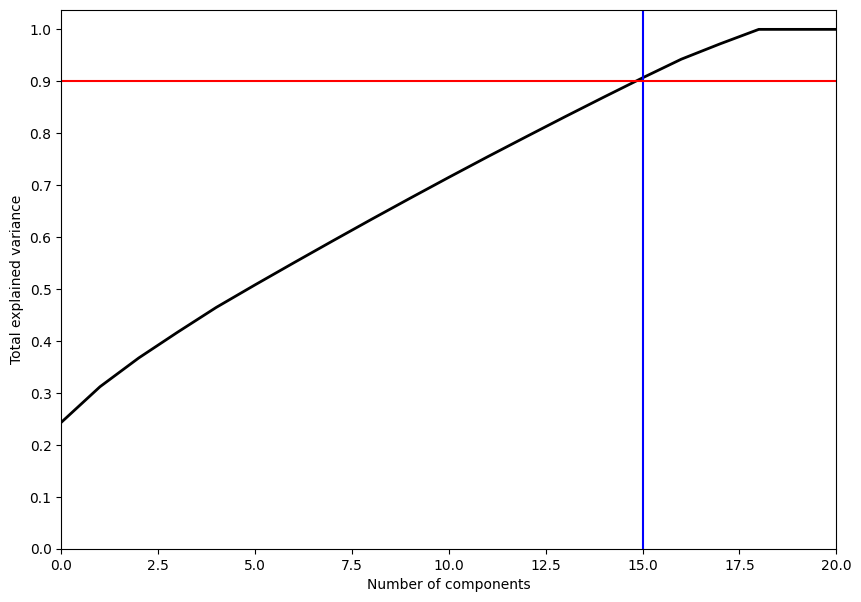

In [344]:
pca = decomposition.PCA().fit(scaled_data)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 20)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(15, c='b')
plt.axhline(0.9, c='r')
plt.show();

##### 3.4.2.2 Selection of optimal components and hyperparameters for DBSCAN

In [345]:
n_components_list = [5, 10, 15]
eps_list = np.linspace(0.1, 1.0, 10)
min_samples_list = [2, 5, 8, 11]
silhouette_scores = []
for n in n_components_list:
    pca_data = PCA(n_components=n).fit_transform(scaled_data)
    for eps, min_samp in itertools.product(eps_list, min_samples_list):
        model = DBSCAN(eps=eps, min_samples=min_samp).fit(pca_data)
        labels = model.labels_

        if len(set(labels)) > 1 and -1 in labels:
            score = silhouette_score(pca_data, labels)
            silhouette_scores.append((n, eps, min_samp, score))

In [346]:
df_silhouette = pd.DataFrame(silhouette_scores, columns=['n_components', 'eps', 'min_samples', 'silhouette_score'])

In [347]:
df_silhouette

,n_components,eps,min_samples,silhouette_score
0,5,0.1,2,-0.710144
1,5,0.1,5,-0.376709
2,5,0.2,2,-0.246759
3,5,0.2,5,-0.496965
4,5,0.2,8,-0.580433
5,5,0.2,11,-0.514628
6,5,0.3,2,-0.037420
7,5,0.3,5,0.249866
8,5,0.3,8,0.183239
9,5,0.3,11,0.067828


## 4.0 Modeling

### 4.1 DBSCAN

In [348]:
pca = PCA(n_components=5)
df_reduced = pca.fit_transform(scaled_data)

In [349]:
dbscan = DBSCAN(eps=0.6, min_samples=2)
labels = dbscan.fit_predict(df_reduced)

In [350]:
print("Cluster value counts:")
print(pd.Series(labels).value_counts())

Cluster value counts:
 15    527
 0     418
 11    412
 17    392
 4     334
 14    305
 5     256
 7     209
 18    199
 2     171
 12    141
 16    101
 3      90
 8      87
 13     79
 6      53
 1      39
 10     38
 19     29
 9      18
-1       2
Name: count, dtype: int64


### 4.2 Agglomerative hierarchical clustering

In [351]:
ahc = linkage(df_reduced, method='complete', metric='euclidean')

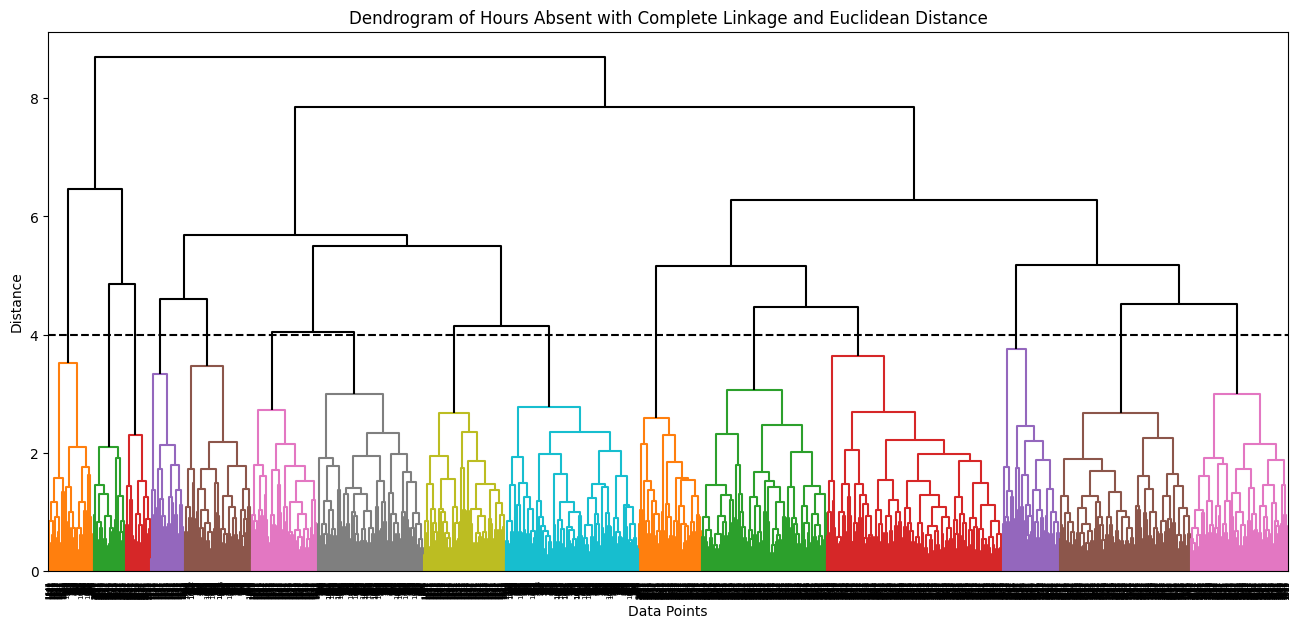

In [352]:
plt.figure(figsize=(16, 7))
dendrogram(ahc, color_threshold = 4, above_threshold_color='black')
plt.title('Dendrogram of Hours Absent with Complete Linkage and Euclidean Distance')
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.axhline(y=4, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.show()

## 5.0 Evaluation

### 5.1 PCA Evaluation

In [353]:
pc1_loadings = pd.Series(pca.components_[0], index=df_scaled.columns)
pc1_loadings_sorted = pc1_loadings.abs().sort_values(ascending=False)

print("Top features contributing to PC1:")
print(pc1_loadings_sorted.head())

Top features contributing to PC1:
Discount Applied_No        0.390277
Promo Code Used_No         0.390277
Discount Applied_Yes       0.390277
Promo Code Used_Yes        0.390277
Subscription Status_Yes    0.328354
dtype: float64


In [354]:
pc2_loadings = pd.Series(pca.components_[1], index=df_scaled.columns)
pc2_loadings_sorted = pc2_loadings.abs().sort_values(ascending=False)

print("Top features contributing to PC2:")
print(pc2_loadings_sorted.head())

Top features contributing to PC2:
Category_Clothing       0.703045
Category_Accessories    0.524888
Item Purchased_freq     0.359645
Category_Footwear       0.303049
Review Rating           0.065973
dtype: float64


In [355]:
pc3_loadings = pd.Series(pca.components_[2], index=df_scaled.columns)
pc3_loadings_sorted = pc3_loadings.abs().sort_values(ascending=False)

print("Top features contributing to PC3:")
print(pc3_loadings_sorted.head())

Top features contributing to PC3:
Category_Footwear       0.676131
Category_Accessories    0.540723
Item Purchased_freq     0.397545
Category_Outerwear      0.143916
Shipping Type_freq      0.102734
dtype: float64


In [356]:
def plot_pca_component_pairs(pca, df_reduced, scale=5):
    """
    Visualize feature loadings across pairs of PCA components.
    Generates subplots for PC1 vs PC2, PC1 vs PC3, and PC2 vs PC3.
    """
    pairs = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
    titles = [
        "PC1 vs PC2",
        "PC1 vs PC3",
        "PC1 vs PC4",
        "PC1 vs PC5",
        "PC2 vs PC3",
        "PC2 vs PC4",
        "PC2 vs PC5",
        "PC3 vs PC4",
        "PC3 vs PC5",
        "PC4 vs PC5"
    ]

    fig, axes = plt.subplots(5, 2, figsize=(12, 26))

    axes = axes.flatten()

    for ax, (i, j), title in zip(axes, pairs, titles):
        for k, feature in enumerate(df_encoded.columns[:pca.components_.shape[1]]):
            ax.arrow(0, 0,
                     pca.components_[i, k] * scale,
                     pca.components_[j, k] * scale,
                     color='black', alpha=0.5, linewidth=0.7)
            ax.text(pca.components_[i, k] * scale * 1.04,
                    pca.components_[j, k] * scale * 1.04,
                    feature, ha='center', va='center', fontsize=8)

        ax.set_xlim(-scale, scale)
        ax.set_ylim(-scale, scale)
        ax.set_xlabel(f"Principal Component {i+1}")
        ax.set_ylabel(f"Principal Component {j+1}")
        ax.set_title(title)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

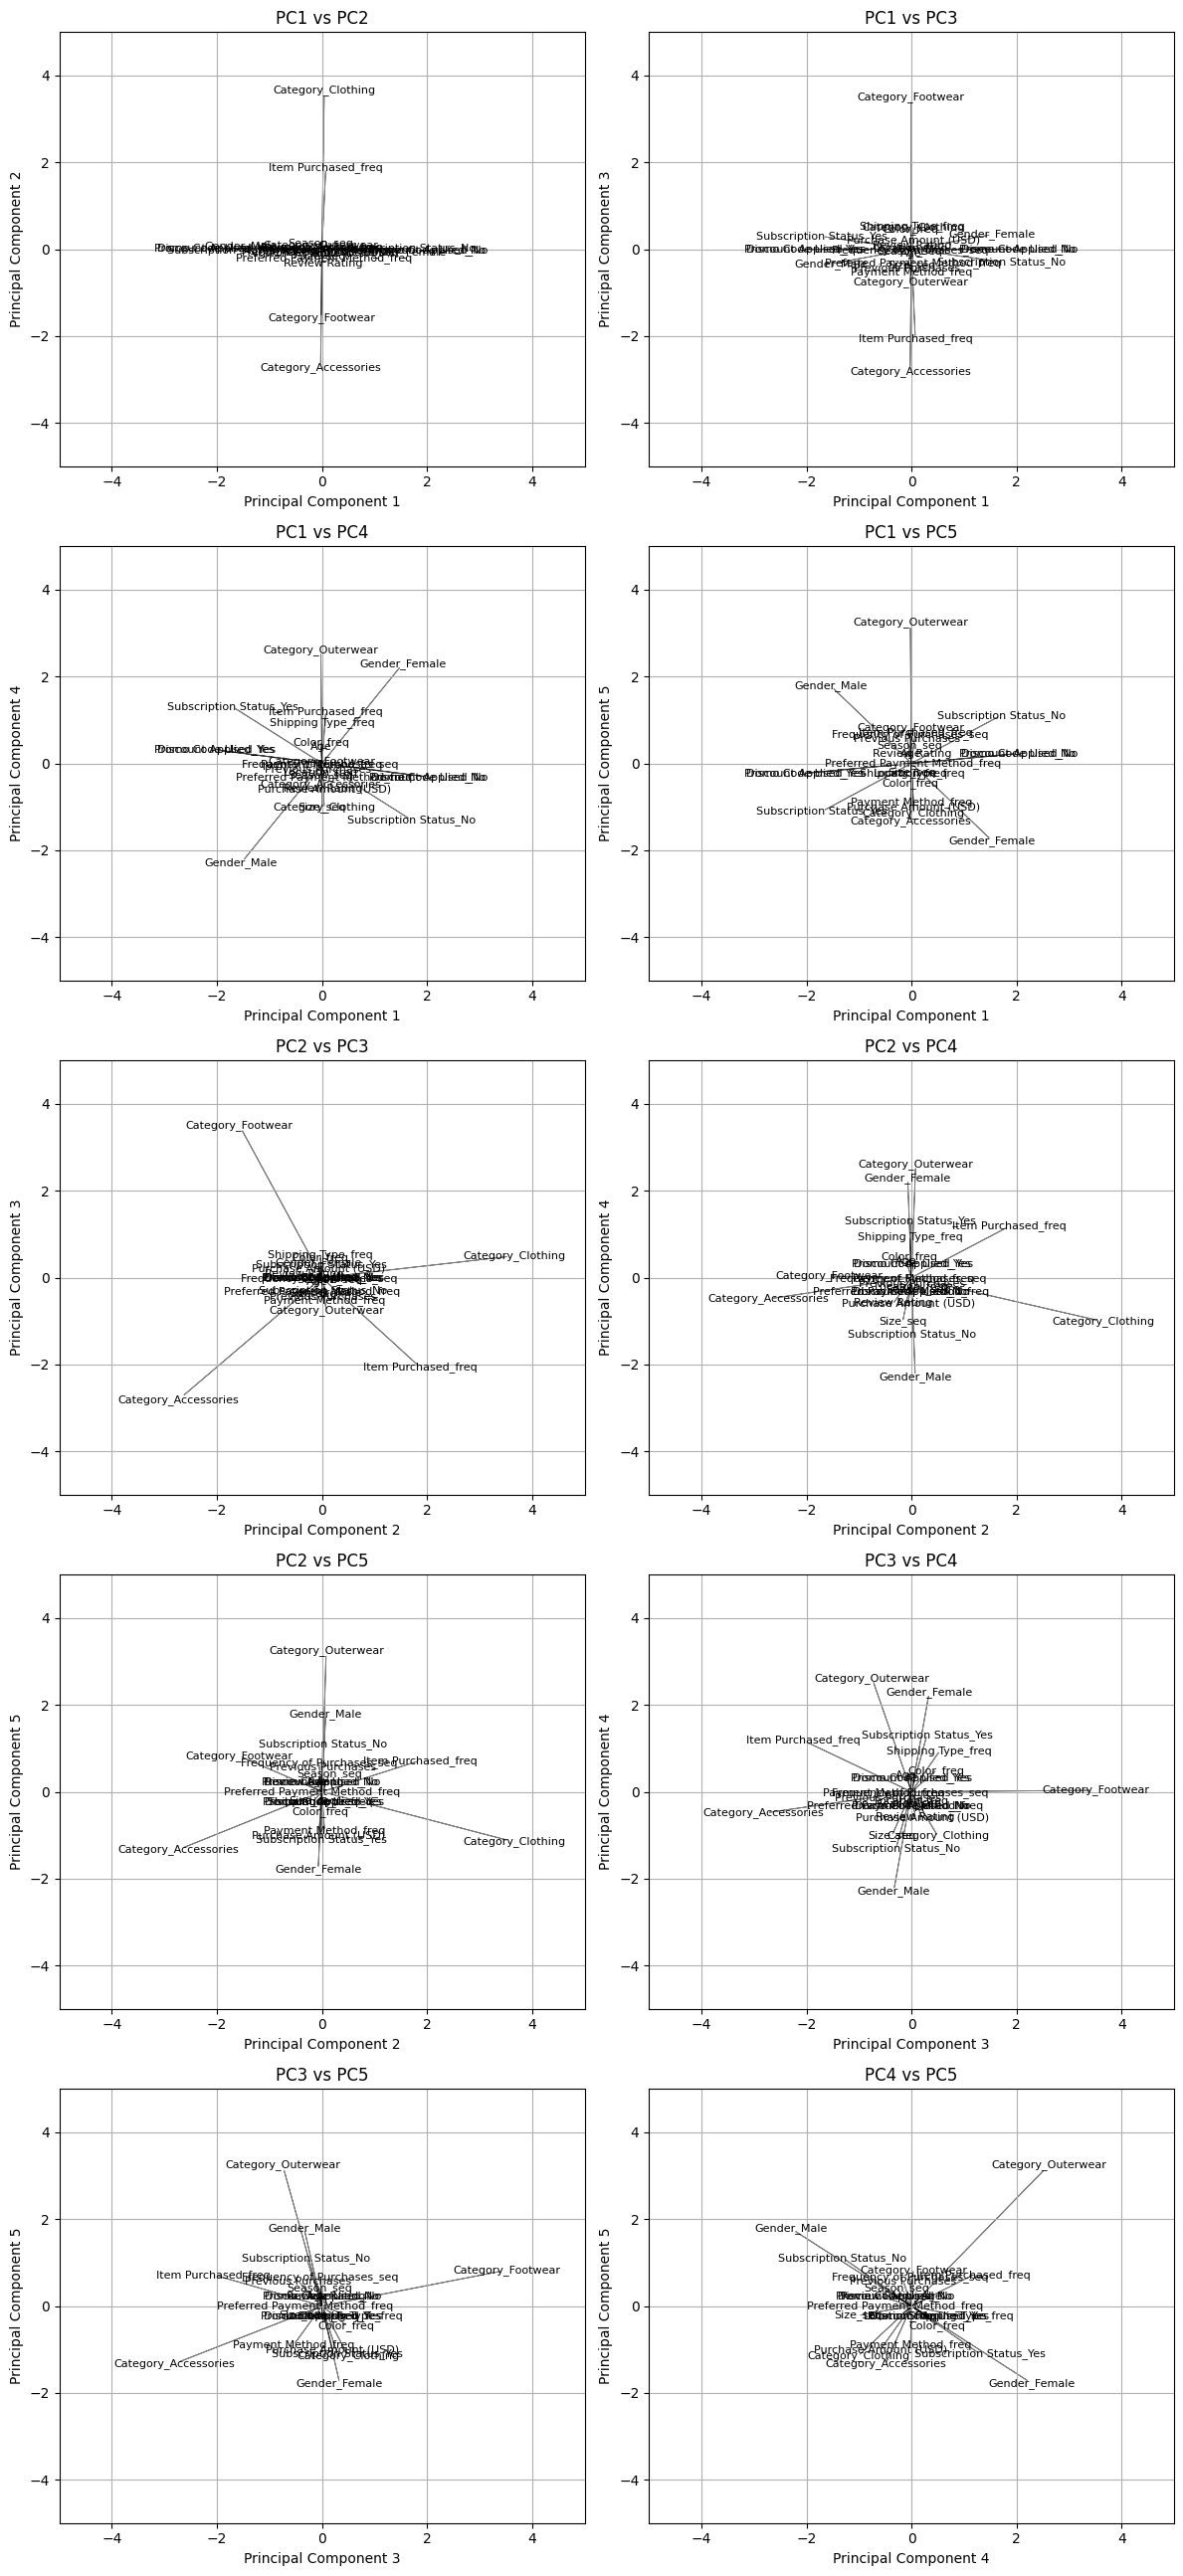

In [357]:
plot_pca_component_pairs(pca, df_reduced)

### 5.2 DBSCAN evaluation

In [358]:
eps_list = np.linspace(0.1, 1.0, 10)
min_samples_list = [2, 5, 8, 11]

In [359]:
silhouette_scores = []

In [360]:
for eps, min_samp in itertools.product(eps_list, min_samples_list):
    model = DBSCAN(eps=eps, min_samples=min_samp).fit(df_reduced)
    labels = model.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        score = silhouette_score(df_reduced, labels)
        silhouette_scores.append((eps, min_samp, n_clusters, score))

In [361]:
df_ssummary = pd.DataFrame(silhouette_scores, columns=['Epsilon', 'Minimum Samples', 'Clusters', 'Silhouette Score'])
df_ssummary

,Epsilon,Minimum Samples,Clusters,Silhouette Score
0,0.1,2,217,-0.710144
1,0.1,5,2,-0.376709
2,0.2,2,405,-0.246759
3,0.2,5,84,-0.496965
4,0.2,8,29,-0.580433
5,0.2,11,12,-0.514628
6,0.3,2,87,-0.037420
7,0.3,5,35,0.249866
8,0.3,8,29,0.183239
9,0.3,11,28,0.067828


### 5.3 Agglomerative hierarchical clustering evaluation

In [362]:
methods_list = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
metrics_list = ['euclidean', 'manhattan', 'cosine', 'correlation']
t_list = [4, 5, 6]

In [363]:
valid_combinations = {
    'single':     ['euclidean', 'cosine', 'correlation'],
    'complete':   ['euclidean', 'cosine', 'correlation'],
    'average':    ['euclidean', 'cosine', 'correlation'],
    'weighted':   ['euclidean', 'cosine', 'correlation'],
    'centroid':   ['euclidean'],
    'median':     ['euclidean'],
    'ward':       ['euclidean']
}

In [364]:
cluster_summary = []

In [365]:
for method in methods_list:
    for metric in valid_combinations[method]:
        try:
            linkage_matrix = linkage(df_reduced, method=method, metric=metric)
            for t in t_list:
                labels = fcluster(linkage_matrix, t=t, criterion='distance')
                n_clusters = len(set(labels))
                if n_clusters > 1:
                    score = silhouette_score(df_reduced, labels)
                    cluster_summary.append((method, metric, t, n_clusters, score))
        except Exception as e:
            print(f"Error with method={method}, metric={metric}, clusters={n_clusters}, t={t}: {e}")

In [366]:
df_csummary = pd.DataFrame(cluster_summary, columns=['Method', 'Metric', 'Dendrogram Cut Threshold', 'Clusters', 'Silhouette Score'])
df_csummary

,Method,Metric,Dendrogram Cut Threshold,Clusters,Silhouette Score
0,complete,euclidean,4,15,0.609279
1,complete,euclidean,5,9,0.466459
2,complete,euclidean,6,5,0.359332
3,average,euclidean,4,4,0.340087
4,average,euclidean,5,2,0.442730
5,weighted,euclidean,4,4,0.340087
6,weighted,euclidean,5,2,0.442730
7,centroid,euclidean,4,2,0.442730
8,median,euclidean,4,2,0.442730
9,ward,euclidean,4,70,0.242077


## 6.0 Deployment

Paper: ComfortJDDS8536-5 - DBSCAN and Hierarchical Clustering Analysis of Customer Shopping Trends